In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset (Before SVD)

In [3]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Reduced by {(start_mem - end_mem) / start_mem:.1%}')

    return df

In [4]:
chunk_size = 100000
chunks = pd.read_csv("00_dataset/without_stopwords/train_features.csv", chunksize=chunk_size, low_memory=False)

df_trainChunks = [reduce_memory(chunk) for chunk in chunks]
df_train = pd.concat(df_trainChunks, axis=0)

# df_train = pd.read_csv("00_dataset/without_stopwords/train_features.csv")

Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.73 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 990.75 MB
Memory usage after optimization: 495.00 MB
Reduced by 50.0%


In [5]:
df_train.dtypes

0                       float32
1                       float32
2                       float32
3                       float32
4                       float32
                         ...   
uppercase_ratio         float32
duplicate_word_count      int16
emoji_count                int8
avg_word_length         float32
label                      int8
Length: 5010, dtype: object

In [6]:
chunk_size = 100000
chunks_test = pd.read_csv("00_dataset/without_stopwords/test_features.csv", chunksize=chunk_size, low_memory=False)
chunks_val = pd.read_csv("00_dataset/without_stopwords/val_features.csv", chunksize=chunk_size, low_memory=False)

df_testChunks = [reduce_memory(chunk_test) for chunk_test in chunks_test]
df_test = pd.concat(df_testChunks, axis=0)

df_valChunks = [reduce_memory(chunk_val) for chunk_val in chunks_val]
df_val = pd.concat(df_valChunks, axis=0)

# df_test = pd.read_csv("00_dataset/without_stopwords/test_features.csv", low_memory=False)
# df_val = pd.read_csv("00_dataset/without_stopwords/val_features.csv", low_memory=False)

Initial memory usage: 3822.33 MB
Memory usage after optimization: 1909.64 MB
Reduced by 50.0%
Initial memory usage: 829.14 MB
Memory usage after optimization: 414.24 MB
Reduced by 50.0%
Initial memory usage: 2325.73 MB
Memory usage after optimization: 1161.94 MB
Reduced by 50.0%


In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.194444,0.9611,73,0,0,0.027708,23,0,4.452055,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.187037,0.9422,46,1,0,0.030534,12,0,4.717391,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.147253,0.7906,38,0,0,0.031579,9,0,4.026316,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.253842,0.9874,108,8,0,0.076923,41,0,4.185185,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.257143,0.8903,53,0,0,0.040134,21,0,4.660378,0


In [8]:
# Separate into X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

X_val = df_val.drop(columns=["label"])
y_val = df_val["label"]

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
ct_mm = ColumnTransformer(transformers=[('MinMaxScaler', MinMaxScaler(), ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 'question_count', 'uppercase_ratio', 'duplicate_word_count', 'emoji_count', 'avg_word_length'])], remainder='passthrough')
X_train_mmscaled = ct_mm.fit_transform(X_train)
X_test_mmscaled = ct_mm.transform(X_test)
X_val_mmscaled = ct_mm.transform(X_val)

In [10]:
import joblib

joblib.dump(ct_mm, '00_dataset/without_stopwords/column_transformer_minMaxScaler.joblib')
print("ColumnTransformer Min Max Scaler saved successfully.")

ColumnTransformer Min Max Scaler saved successfully.


In [8]:
# Load Min Max Scaler
ct_mm = joblib.load('00_dataset/without_stopwords/column_transformer_minMaxScaler.joblib')
# X_train_mmscaled = ct_mm.fit_transform(X_train)
X_test_mmscaled = ct_mm.transform(X_test)
X_val_mmscaled = ct_mm.transform(X_val)

In [11]:
# Check class distribution after split
print("Train Class Distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation Class Distribution:\n", y_val.value_counts(normalize=True))
print("\nTest Class Distribution:\n", y_test.value_counts(normalize=True))

Train Class Distribution:
 label
0    0.867799
1    0.132201
Name: proportion, dtype: float64

Validation Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64

Test Class Distribution:
 label
0    0.867797
1    0.132203
Name: proportion, dtype: float64


In [12]:
print("Contains negative values:", np.any(X_train_mmscaled < 0))


Contains negative values: False


In [28]:
import joblib
import os

os.makedirs('00_dataset/without_stopwords/nb_balanced', exist_ok=True)

# Define the model
nb = MultinomialNB()

batch_size = 50000
num_batches = int(np.ceil(X_train_mmscaled.shape[0] / batch_size))

for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, X_train_mmscaled.shape[0])
    
    X_batch = X_train_mmscaled[start:end]
    y_batch = y_train[start:end]
    
    if i == 0:
        # Initial fit with all possible classes
        nb.partial_fit(X_batch, y_batch, classes=np.array([0, 1]))
    else:
        nb.partial_fit(X_batch, y_batch)
    
    # Save the model after each batch
    joblib.dump(nb, f'00_dataset/without_stopwords/nb_balanced/multinomial_nb_batch_{i}.joblib')
    print(f'Batch {i+1}/{num_batches} completed and saved.')


Batch 1/9 completed and saved.
Batch 2/9 completed and saved.
Batch 3/9 completed and saved.
Batch 4/9 completed and saved.
Batch 5/9 completed and saved.
Batch 6/9 completed and saved.
Batch 7/9 completed and saved.
Batch 8/9 completed and saved.
Batch 9/9 completed and saved.


In [13]:
nb = MultinomialNB(class_prior=[0.5, 0.5])
nb.fit(X_train_mmscaled, y_train)

# Save the model
joblib.dump(nb, '00_dataset/without_stopwords/beforeSVD/nb/nb_balanced.joblib')
print("Naive Bayes training completed and saved.")

Naive Bayes training completed and saved.


Validation Accuracy: 0.6436

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     52802
           1       0.22      0.68      0.34      8044

    accuracy                           0.64     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.84      0.64      0.70     60846

ROC-AUC Score:  0.7201675725368735


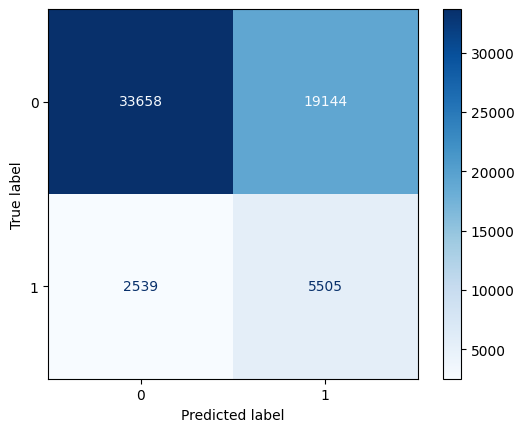

In [14]:
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Load the last saved model
nb = joblib.load('00_dataset/without_stopwords/beforeSVD/nb/nb_balanced.joblib')

# Predict on validation data
y_val_pred = nb.predict(X_val_mmscaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb.predict_proba(X_val_mmscaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [19]:
lr = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight='balanced', random_state=42)
lr.fit(X_train_mmscaled, y_train)

KeyboardInterrupt: 

In [22]:
joblib.dump(lr, '00_dataset/without_stopwords/beforeSVD/lr/lr_balanced.joblib')
print("Logistic Regression training completed and saved.")

Logistic Regression training completed and saved.


In [18]:
# Load your trained Logistic Regression model
#model = joblib.load('00_dataset/without_stopwords/beforeSVD/lr/lr_balanced.joblib')

# Predict on test set
y_pred = lr.predict(X_val_mmscaled)

# Evaluate Baseline Performance
print("Accuracy: ", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = lr.predict_proba(X_val_mmscaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

Accuracy:  0.6772507642244354
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     52802
           1       0.22      0.68      0.34      8044

    accuracy                           0.64     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.84      0.64      0.70     60846

ROC-AUC Score:  0.7379880466814739


Recall for Class 1 (Spam) is 0 suggests that the model is failing at predicting Class 1. But when it is predicts Spam, the precision of 22% suggests that is is correct 22% of the time.

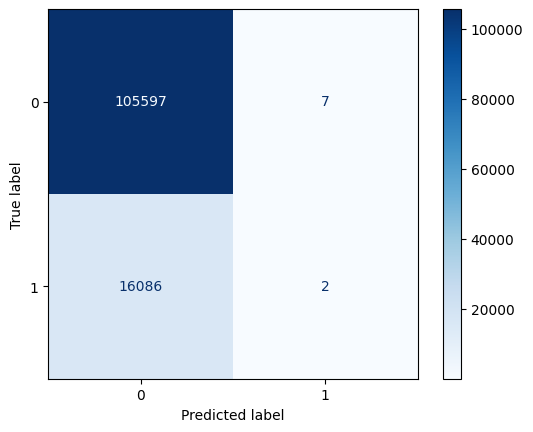

In [22]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

## Balanced Model

In [ ]:
import joblib
import os

os.makedirs('00_dataset/without_stopwords/nb_classweights', exist_ok=True)

# Define the model
nb = MultinomialNB(class_prior=[0.5, 0.5])

batch_size = 50000
num_batches = int(np.ceil(X_train_mmscaled.shape[0] / batch_size))

for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, X_train_mmscaled.shape[0])
    
    X_batch = X_train_mmscaled[start:end]
    y_batch = y_train[start:end]
    
    if i == 0:
        # Initial fit with all possible classes
        nb.partial_fit(X_batch, y_batch, classes=np.array([0, 1]))
    else:
        nb.partial_fit(X_batch, y_batch)
    
    # Save the model after each batch
    joblib.dump(nb, f'00_dataset/without_stopwords/nb_classweights/multinomial_nb_batch_{i}.joblib')
    print(f'Batch {i+1}/{num_batches} completed and saved.')

Batch 1/9 completed and saved.
Batch 2/9 completed and saved.
Batch 3/9 completed and saved.
Batch 4/9 completed and saved.
Batch 5/9 completed and saved.
Batch 6/9 completed and saved.
Batch 7/9 completed and saved.
Batch 8/9 completed and saved.
Batch 9/9 completed and saved.


c:\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.6.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Validation Accuracy: 0.6436

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     52802
           1       0.22      0.68      0.34      8044

    accuracy                           0.64     60846
   macro avg       0.58      0.66      0.55     60846
weighted avg       0.84      0.64      0.70     60846

ROC-AUC Score:  0.7201675725368735


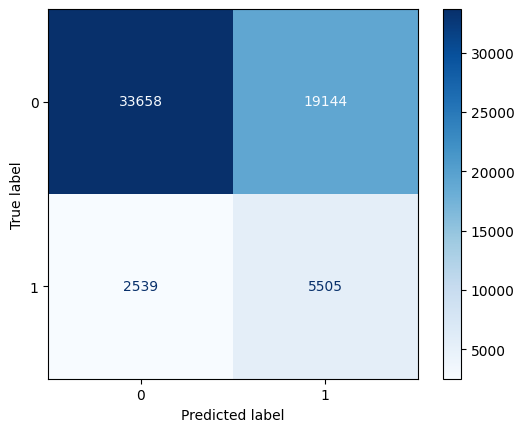

In [16]:
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Load the last saved model
nb_classweights = joblib.load('00_dataset/without_stopwords/nb_classweights/multinomial_nb_batch_8.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = nb_classweights.predict(X_val_mmscaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_classweights.predict_proba(X_val_mmscaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [ ]:
import joblib

os.makedirs('00_dataset/without_stopwords/lr_classweights', exist_ok=True)

lr = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, random_state=42, class_weight='balanced')
lr.fit(X_train_mmscaled, y_train)

joblib.dump(lr, '00_dataset/without_stopwords/lr_classweights/lr_full.joblib')
print("Logistic Regression training completed and saved.")

c:\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Validation Accuracy: 0.6773

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.68      0.78     52802
           1       0.24      0.67      0.35      8044

    accuracy                           0.68     60846
   macro avg       0.59      0.67      0.57     60846
weighted avg       0.84      0.68      0.73     60846

ROC-AUC Score:  0.7379876464359472


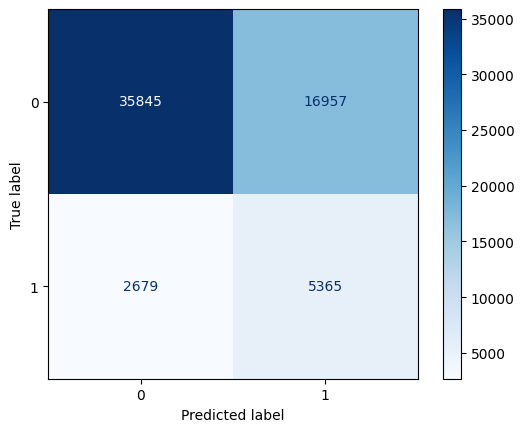

In [19]:
# Load the last saved model
lr_classweights = joblib.load('00_dataset/without_stopwords/lr_classweights/lr_full.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = lr_classweights.predict(X_val_mmscaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = lr_classweights.predict_proba(X_val_mmscaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

# Apply SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_mmscaled, y_train)

In [ ]:
nb_smote = MultinomialNB(class_prior=[0.5, 0.5])
nb_smote.fit(X_train_smote, y_train_smote)

# Save the model
joblib.dump(nb_smote, '00_dataset/without_stopwords/nb_classweights/nb_smote.joblib')
print("Naive Bayes with SMOTE training completed and saved.")

c:\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.6.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Validation Accuracy: 0.6927

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80     52802
           1       0.24      0.60      0.34      8044

    accuracy                           0.69     60846
   macro avg       0.58      0.65      0.57     60846
weighted avg       0.83      0.69      0.74     60846

ROC-AUC Score:  0.7142543427722655


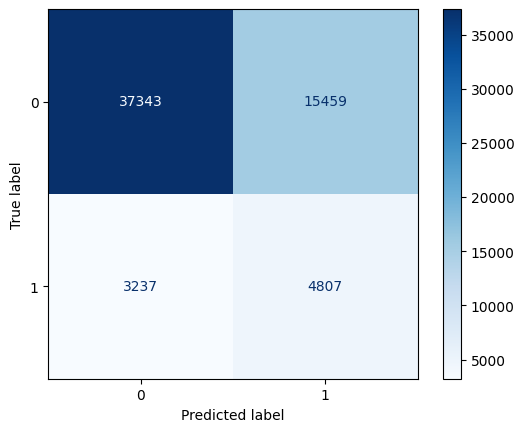

In [17]:
# Load the last saved model
nb_smote = joblib.load('00_dataset/without_stopwords/nb_classweights/nb_smote.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = nb_smote.predict(X_val_mmscaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = nb_smote.predict_proba(X_val_mmscaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization

In [ ]:
# Train Logistic Regression
lr_smote = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')
lr_smote.fit(X_train_smote, y_train_smote)

# Save the model
joblib.dump(lr_smote, '00_dataset/without_stopwords/lr_classweights/lr_smote.joblib')
print("Logistic Regression with SMOTE training completed and saved.")

c:\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Validation Accuracy: 0.7791

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87     52802
           1       0.27      0.41      0.33      8044

    accuracy                           0.78     60846
   macro avg       0.59      0.62      0.60     60846
weighted avg       0.82      0.78      0.80     60846

ROC-AUC Score:  0.7093078448631763


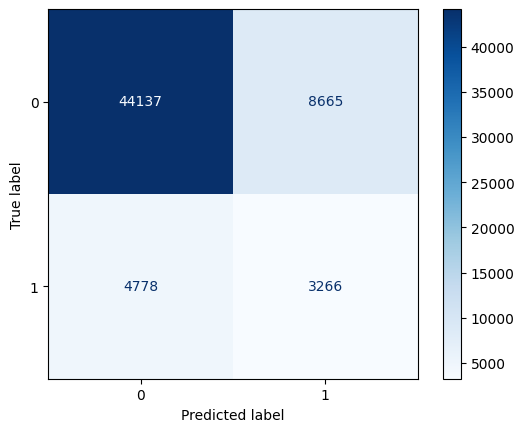

In [18]:
# Load the last saved model
lr_smote = joblib.load('00_dataset/without_stopwords/lr_classweights/lr_smote.joblib') # Replace X with the last batch number

# Predict on validation data
y_val_pred = lr_smote.predict(X_val_mmscaled)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Compute ROC-AUC
y_proba = lr_smote.predict_proba(X_val_mmscaled)[:, 1]
print("ROC-AUC Score: ", roc_auc_score(y_val, y_proba))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Choose a color map for visualization